In [1]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import torch
# import seaborn as sns

from gglm.glm.wglm_cnn import WGLM
from gglm.cnncritic import CNNCritic
from sptr.sptr import SpikeTrain
from gglm.utils import shift_array
from kernel.fun import KernelFun
from kernel.rect import KernelRect

%load_ext autoreload
%autoreload 2

In [2]:
npz = np.load('./fr_mismatch.npz')
t, stim, mask_spikes_te, u_spk_mean_te, mask_spikes_fr, u_spk_mean_fr  = npz['t'], npz['stim'], npz['mask_spikes_te'], npz['u_spk_mean_te'], npz['mask_spikes_fr'], npz['u_spk_mean_fr']
u_te, u_fr = npz['u_te'], npz['u_fr']
r_te, r_fr = npz['r_te'], npz['r_fr']
u0_ml, eta_vals_ml = npz['glm_u0'], npz['glm_eta']

dt = t[1]

n_batch_te = mask_spikes_te.shape[1]
n_batch_fr = mask_spikes_fr.shape[1]

st_te = SpikeTrain(t, mask_spikes_te)
st_fr = SpikeTrain(t, mask_spikes_fr)

mask_spikes = np.concatenate((mask_spikes_te, mask_spikes_fr), axis=1)
n_spikes_te = np.sum(mask_spikes_te, 0)
n_spikes_fr = np.sum(mask_spikes_fr, 0)
mask_spikes_te = torch.from_numpy(mask_spikes_te)
mask_spikes = torch.from_numpy(mask_spikes).double()
# y = np.concatenate((np.ones(mask_spikes_te.shape[1]), np.zeros(mask_spikes_fr.shape[1])))
y = torch.cat((torch.ones(n_batch_te), torch.zeros(n_batch_fr))).double()
u = torch.from_numpy(np.concatenate((u_te, u_fr), axis=1)).double()
r = torch.from_numpy(np.concatenate((r_te, r_fr), axis=1)).double()

x = torch.stack((mask_spikes.T, u.T), dim=1)
# x = u.T[:, None, :].clone()

ms = 1

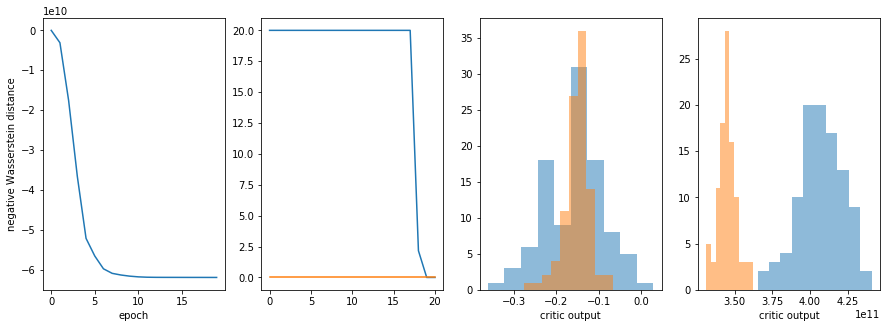

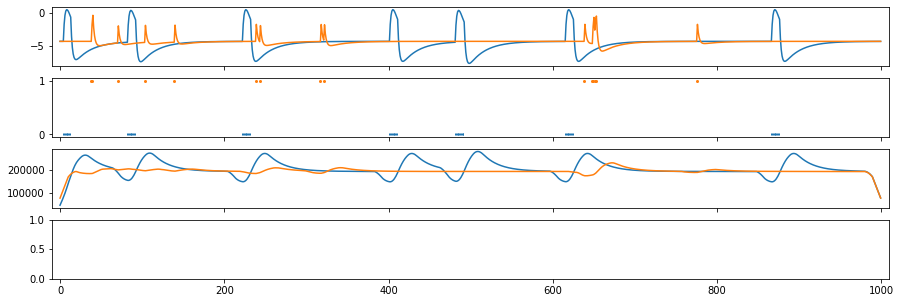

In [3]:
lam_w, num_epochs, lr_g, lr_c, clip = 1e0, 10, 2e-2, 1e1, 1e1 # normalized

critic_inputs = 'mask_spikesu'

critic = CNNCritic(n=mask_spikes.shape[0], n_in=2, two_layers=True, avg_pooling=False, kernel_size=21, 
                   cnn_bias=True, weight_normalization=False, cnn_output_window=1000, clip=clip)
output0 = critic(x)
output0 = output0.detach().numpy()

neg_w_distance = critic.train(x, y, lam_w, lr=lr_c, num_epochs=20)

output = critic(x)
output = output.detach().numpy()
cnn_output = critic.cnn_layers(x).detach().numpy()
cnn_output_te = cnn_output[:n_batch_te, :, :]
cnn_output_fr = cnn_output[n_batch_te:, :, :]

sw = 0
t_cnn_output = np.arange(0, cnn_output_te.shape[2], 1) * len(t) // critic.cnn_output_window

kernel, bias = critic.cnn_layers[0].weight, critic.cnn_layers[0].bias
# kernel, bias = critic.cnn_spikes_layers[0].weight, critic.cnn_spikes_layers[0].bias
if bias is None:
    bias = 0
    kernel = kernel.detach().numpy()
else:
    kernel = kernel.detach().numpy() + bias.detach().numpy()[:, None, None]
    
kernel0 = kernel.copy()
critic0 = copy.copy(critic)
    
t_kernel = np.arange(0, kernel.shape[2], 1) * dt

fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(15, 5), ncols=4)
ax1.plot(neg_w_distance)
ax1.set_xlabel('epoch')
ax1.set_ylabel('negative Wasserstein distance')
ax2.plot(t_kernel, kernel[0, 0, :])
if kernel.shape[0] > 1:
    ax2.plot(t_kernel, kernel[1, 0, :])
ax3.hist(output0[y == 1], alpha=0.5)
ax3.hist(output0[y == 0], alpha=0.5)
ax4.hist(output[y == 1], alpha=0.5)
ax4.hist(output[y == 0], alpha=0.5)
ax3.set_xlabel('critic output')
ax4.set_xlabel('critic output')

output0 = output.copy()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(15, 5), nrows=4, sharex=True)
ax1.plot(t, u_te[:, sw])
ax1.plot(t, u_fr[:, sw])
st_te.plot(ax=ax2, sweeps=sw, marker='|', ms=2)
st_fr.plot(ax=ax2, offset=1, sweeps=sw, ms=2, color='C1')
# ax2.plot(t, r_fr[:, 0])
ax3.plot(t, cnn_output_te[sw, 0, :])
ax3.plot(t, cnn_output_fr[sw, 0, :])
if cnn_output_te.shape[1] > 1:
    ax4.plot(t, cnn_output_te[sw, 1, :])
    ax4.plot(t, cnn_output_fr[sw, 1, :])
# ax1.plot(t, critic_conv_fr[:, 0])

 epoch 49 of 50 loss 10379.2204

(array([ 7., 13., 27., 21., 17.,  3.,  5.,  4.,  2.,  1.]),
 array([ 5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5, 25. , 27.5, 30. ]),
 <a list of 10 Patch objects>)

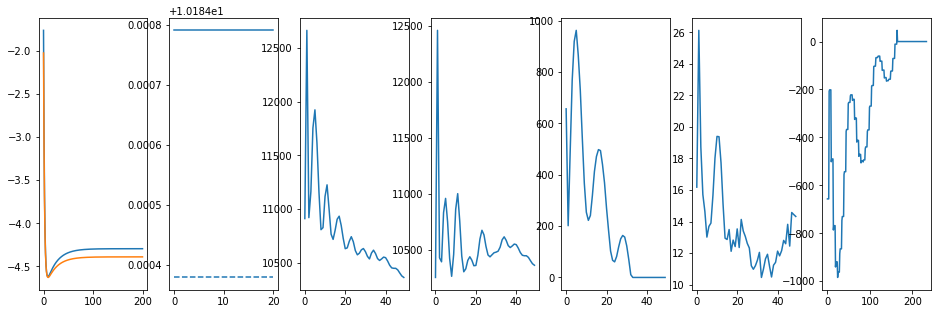

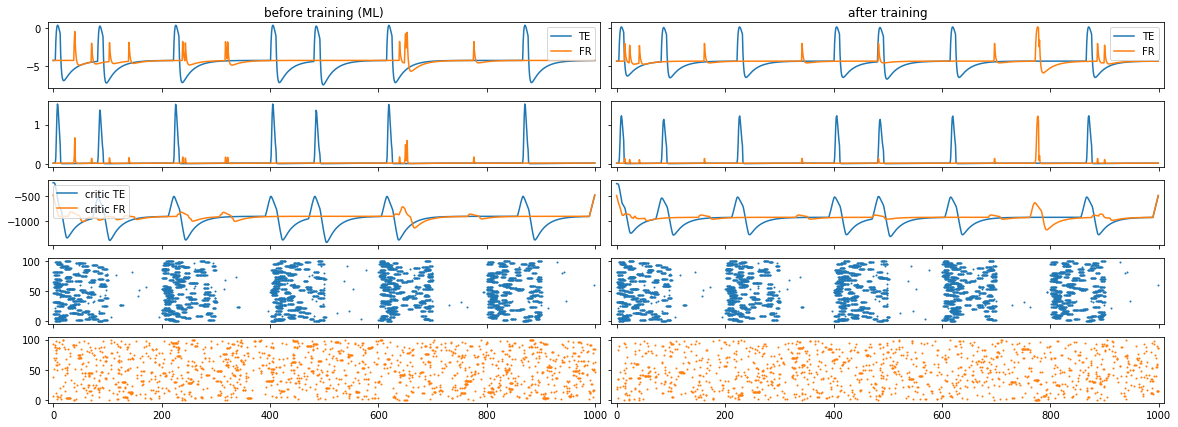

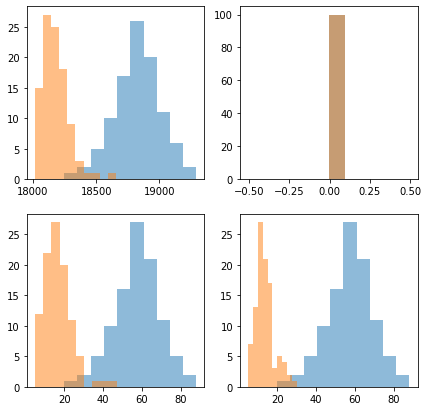

In [4]:
lam_w, num_epochs, lr_g, lr_c, clip = 5e-5, 250, 5e-2, 1e1, 1e1 # with cnn_bias
num_epochs_c = 10

# lam_w = 5e-2
# cnn_output_window = 1
# two_layers, critic_inputs, num_epochs, lr_g = True, 'mask_spikesu', 100, 1e-1
# x = torch.stack((mask_spikes.T.clone(), u.T.clone()), dim=1)

lam_w = 5e-2
cnn_output_window = 1
two_layers, critic_inputs, num_epochs, lr_g = False, 'u', 50, 1e-1
x = u.T[:, None, :].clone()

eta_ml = KernelFun.exponential(tau=np.array([2, 20]), coefs=eta_vals_ml.copy())

critic = CNNCritic(n=mask_spikes.shape[0], n_in=x.shape[1], two_layers=two_layers, kernel_size=21, 
                   cnn_bias=True, weight_normalization=False, cnn_output_window=cnn_output_window, clip=clip)
neg_w_distance = critic.train(x, y, lam_w, lr=lr_c, num_epochs=20)
output0 = lam_w * critic(x)
output0 = output0.detach().numpy()
kernel0, bias = critic.cnn_layers[0].weight, critic.cnn_layers[0].bias
if bias is None:
    bias = 0
    kernel0 = kernel0.detach().numpy()
else:
    kernel0 = kernel0.detach().numpy() + bias.detach().numpy()[:, None, None]
cnn_output = critic.cnn_layers(x).detach().numpy()
cnn_output_te = cnn_output[:n_batch_te, :, :]
cnn_output_fr = cnn_output[n_batch_te:, :, :]

wglm = WGLM(u0=float(u0_ml), eta=eta_ml.copy(), critic=critic, critic_inputs=critic_inputs)
# wglm = WGLM(u0=4, eta=eta_ml.copy(), critic=critic)

loss, w_distance, neg_w_distance, n_spikes = wglm.train(t, mask_spikes_te, y, lam_w=lam_w, lr_g=lr_g, lr_c=lr_c, num_epochs=num_epochs, 
                                              num_epochs_c=num_epochs_c, n_batch_fr=n_batch_fr, verbose=True)
loss, w_distance, neg_w_distance, n_spikes = np.array(loss), np.array(w_distance), np.array(neg_w_distance), np.array(n_spikes)

u_new_fr, r_new_fr, mask_spikes_new_fr = wglm.sample(t, shape=(n_batch_fr,))
u_new_te, r_new_te = wglm.simulate_subthreshold(t, np.zeros(mask_spikes_te.shape), mask_spikes_te)

mask_spikes_new = np.concatenate((mask_spikes_te, mask_spikes_new_fr), axis=1)
n_spikes_new_fr = np.sum(mask_spikes_new_fr, 0)
mask_spikes_new = torch.from_numpy(mask_spikes_new).double()
u_new = torch.from_numpy(np.concatenate((u_new_te, u_new_fr), axis=1)).double()
r_new = np.concatenate((r_new_te, r_new_fr), axis=1)
r_new = torch.from_numpy(r_new)
# x = torch.stack((mask_spikes_new.T, u_new.T), dim=1)
x_new = wglm.critic_input_x(u_new, r_new, mask_spikes_new)

# output00 = lam_w * output0.copy()
output = lam_w * wglm.critic(x)
output = output.detach().numpy()
cnn_output_new = wglm.critic.cnn_layers(x_new).detach().numpy()
cnn_output_new_te = cnn_output_new[:n_batch_te, :, :]
cnn_output_new_fr = cnn_output_new[n_batch_te:, :, :]


kernel, bias = wglm.critic.cnn_layers[0].weight, wglm.critic.cnn_layers[0].bias
if bias is None:
    bias = 0
    kernel = kernel.detach().numpy()
else:
    kernel = kernel.detach().numpy() + bias.detach().numpy()[:, None, None]

t_kernel = np.arange(0, kernel.shape[2], 1) * dt

fig, (ax0, ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(figsize=(16, 5), ncols=7)
ti = np.arange(wglm.eta.support[0], wglm.eta.support[1], .1)
vals_ml = -eta_ml.interpolate(ti) - u0_ml
vals = -wglm.eta.interpolate(ti) - wglm.u0
ax0.plot(ti, vals_ml)
ax0.plot(ti, vals)
ax1.plot(t_kernel, kernel0[0, 0, :], '--', color='C0')
if kernel0.shape[0] > 1:
    ax1.plot(t_kernel, kernel0[1, 0, :], '--', color='C1')
ax1.plot(t_kernel, kernel[0, 0, :])
if kernel.shape[0] > 1:
    ax1.plot(t_kernel, kernel[1, 0, :])
ax2.plot(loss)
ax3.plot(loss - w_distance)
ax4.plot(w_distance)
ax5.plot(n_spikes)
ax6.plot(neg_w_distance)

fig, ((ax00, ax01), (ax10, ax11), (ax20, ax21), (ax30, ax31), (ax40, ax41)) = plt.subplots(figsize=(20, 7), nrows=5, ncols=2, 
                                                                                           sharex=True, sharey='row')
fig.subplots_adjust(wspace=0.02)

ax00.set_title('before training (ML)')
ax00.plot(t, u_te[:, 0], label='TE')
ax00.plot(t, u_fr[:, 0], label='FR')
ax00.legend()
ax10.plot(t, r_te[:, 0])
ax10.plot(t, r_fr[:, 0])
ax20.plot(t, cnn_output_te[0, 0, :], label='critic TE')
ax20.plot(t, cnn_output_fr[0, 0, :], label='critic FR')
# ax20.plot(t, (critic_conv_te * r_te)[:, 0])
# ax20.plot((critic_conv_fr * r_fr)[:, 0])
ax20.legend()
SpikeTrain(t, mask_spikes_te.numpy()).plot(ax=ax30, ms=ms, color='C0')
SpikeTrain(t, mask_spikes_fr).plot(ax=ax40, ms=ms, color='C1')

ax01.set_title('after training')
ax01.plot(t, u_new_te[:, 0], label='TE')
ax01.plot(t, u_new_fr[:, 0], label='FR')
ax01.legend()
ax11.plot(t, r_new_te[:, 0])
ax11.plot(t, r_new_fr[:, 0])
ax21.plot(t, cnn_output_new_te[0, 0, :], label='critic TE')
ax21.plot(t, cnn_output_new_fr[0, 0, :], label='critic FR')
# ax21.plot(t, (critic_conv_te * r_te)[:, 0])
# ax21.plot((critic_conv_fr * r_fr)[:, 0])
SpikeTrain(t, mask_spikes_te.numpy()).plot(ax=ax31, ms=ms, color='C0')
SpikeTrain(t, mask_spikes_new_fr).plot(ax=ax41, ms=ms, color='C1')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(7, 7), nrows=2, ncols=2)
ax1.hist(output0[y == 1], alpha=0.5)
ax1.hist(output0[y == 0], alpha=0.5)
ax2.hist(output[y == 1], alpha=0.5)
ax2.hist(output[y == 0], alpha=0.5)

ax3.hist(n_spikes_te, alpha=0.5)
ax3.hist(n_spikes_fr, alpha=0.5)
ax4.hist(n_spikes_te, alpha=0.5)
ax4.hist(n_spikes_new_fr, alpha=0.5)

# ax1.set_title('ML (before Wasserstein GLM training)')
# ax2.set_title('After')
# ax1.set_xlabel('some feature') 
# ax2.set_xlabel('some feature')
# ax3.set_xlabel('# spikes')
# ax4.set_xlabel('# spikes')


In [52]:
u, r2 = wglm.simulate_subthreshold(t, np.zeros(mask_spikes_new_fr.shape), mask_spikes_new_fr)
a2 = critic.transform(t, mask_spikes_new_fr, r2)

fig, ax = plt.subplots()
ax.hist(a_fr.detach().numpy(), alpha=0.5)
ax.hist(a_new_fr.detach().numpy(), alpha=0.5)
ax.hist(a2.detach().numpy(), alpha=0.5)

ValueError: operands could not be broadcast together with shapes (1000,200) (1000,100) 

In [ ]:
eta_ml = KernelFun.exponential(tau=np.array([2, 20]), coefs=eta_vals_ml.copy())

wglm = WGLM(u0=u0_ml, eta=eta_ml.copy(), critic=critic.copy())

newton_kwargs_critic = dict(max_iterations=20, learning_rate=1e0, use_hessian=False, warm_up_iterations=3, 
                            clip_theta=clip_theta, stop_cond=1e-8)
newton_kwargs = dict(max_iterations=40, learning_rate=1e-1, use_hessian=True, stop_cond=1e-12)
optimizer = wglm.fit(t, mask_spikes, newton_kwargs=newton_kwargs, verbose=True, n_samples_fr=200,
            newton_kwargs_critic=newton_kwargs_critic)

stim_naive = np.zeros((len(t), 200))


fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(figsize=(16, 4), ncols=5)
# eta_ml.plot(ax=ax0, invert_values=True)
# wglm.eta.plot(ax=ax0, invert_values=True)
t_ = np.arange(eta_ml.support[0], eta_ml.support[1], .1)
a = -eta_ml.interpolate(t_) - u0_ml
b = -wglm.eta.interpolate(t_) - wglm.u0
ax0.plot(t_, a)
ax0.plot(t_, b)
ax1.plot(optimizer.obj_iterations)
ax2.plot(optimizer.obj_iterations - optimizer.metrics_iterations['c_w_distance'])
# ax3.plot(optimizer.metrics_iterations['c_w_distance'])
ax3.plot(optimizer.metrics_iterations['w_distance'])
ax4.plot(np.concatenate((optimizer.metrics_iterations['w_distance2'])))

ax1.set_title('objective')
ax2.set_title('log-likelihood')
ax3.set_title('wasserstein distance')
ax4.set_title('wasserstein distance')

if wglm.critic.u_kernel is not None:
    fig, (ax0, ax1) = plt.subplots(figsize=(16, 5), ncols=2)
    wglm.critic.u_kernel.plot(ax=ax0, invert_values=True)

In [ ]:
a = critic.transform(t, mask_spikes, u, r, u0=u0_ml)
a_new_te = wglm.critic.transform(t, mask_spikes_te, u_new_te, r_new_te, u0=wglm.u0)
a_new_fr = wglm.critic.transform(t, mask_spikes_fr, u_new_fr, r_new_fr, u0=wglm.u0)
# a = a - np.mean(a[y == 0])
# a_new_te = a_new_te - np.mean(a_new_fr)
# a_new_fr = a_new_fr - np.mean(a_new_fr)

n_spikes_te = np.sum(mask_spikes_te, 0)
n_spikes_fr = np.sum(mask_spikes_fr, 0)
n_spikes_new_fr = np.sum(mask_spikes_new_fr, 0)

fig, (ax1, ax2) = plt.subplots(figsize=(15, 5), nrows=2)
ax1.plot(u_new_te[:, 0])
ax1.plot(u_new_fr[:, 0])
ax2.plot(r_new_te[:, 0])
ax2.plot(r_new_fr[:, 0])
# ax.plot(mask_spikes_te[:, 0])



In [ ]:
fig, ax = plt.subplots()
z = np.random.rand(100)
ax.plot(np.zeros(len(z)), z, 'o', ms=1)
ax.plot(np.ones(len(z)), z, 'o', ms=1)
ax.set_xlim(-1, 2)
ax.set_xticks([0, 1])
# ax.set_xticklabels([0, '$\theta$'])
ax.set_xticklabels([0, r"$\theta$"])